In [1]:
import numpy as np
import torch as t
import os
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from collections import defaultdict

In [2]:
model_name = "pythia-70m-deduped"
n_feats_per_submod = 512 * 64
n_submod = 6
n_total_feats = n_feats_per_submod * n_submod
random_seed = 42

device = "cuda:0"
num_svd_components = 900 # With 1024 components and percentage 0.9, truncation dim is 805
singular_value_cutoff = 0.95

activations_dir = "/home/can/feature_clustering/activations"
svd_dir = "/home/can/feature_clustering/svd"
loss_threshold = 0.03
skip = 512
num_tokens = 10000
n_pos = 10
submod_type_names = "mlp"


score_metric = "act-grad"
feature_pattern_reduction_across_positions = "sum" # "sum" or "pos"

param_summary = f"{model_name}_tloss{loss_threshold}_ntok{num_tokens}_skip{skip}_npos{n_pos}_{submod_type_names}"
svd_filename = f"svd-comp{num_svd_components}_{score_metric}_{param_summary}.pt"

In [3]:
contexts_y_filename = '/home/can/feature_clustering/contexts/contexts_pythia-70m-deduped_tloss0.03_ntok10000_skip512_npos10_mlp.json'
contexts_y = json.load(open(contexts_y_filename, "r"))

In [4]:
# Load feature activations and gradients on 1k contexts
act_grad_filename = f"act-n-grad-cat_{param_summary}.json"
act_per_context = json.load(open(os.path.join(activations_dir, act_grad_filename), "r"))
y_global_idx = np.array(list(act_per_context.keys()), dtype=int)
num_y = len(act_per_context)

X = t.zeros((num_y, n_total_feats))
for row, context in tqdm(enumerate(act_per_context), desc="Loading into matrix, Row", total=num_y):
    for col, act, grad in act_per_context[context][feature_pattern_reduction_across_positions]:
        col = int(col)
        if score_metric == "act":
            X[row, col] = act
        elif score_metric == "act-grad":
            X[row, col] = act * grad
        else:
            raise ValueError("Unknown score_metric")
X.to_sparse().to(device)
print(f'X shape: {X.shape}')
del act_per_context

Loading into matrix, Row: 100%|██████████| 10000/10000 [03:34<00:00, 46.51it/s]


X shape: torch.Size([10000, 196608])


In [5]:
U, S, V = t.load(os.path.join(svd_dir, svd_filename))

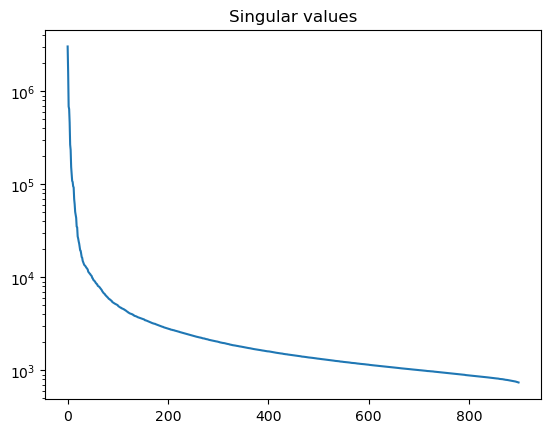

In [6]:
# Plot singular values
plt.plot(S)
plt.title("Singular values")
plt.yscale("log")
plt.show()

In [7]:
# Truncate 
def find_cutoff_index_numpy(a):
    # Step 1: Normalize the array
    normalized_a = a / np.sum(a)

    # Step 2: Find the cutoff index using np.cumsum
    cumulative_sum = np.cumsum(normalized_a)

    # Find the index where cumulative sum exceeds or equals 90%
    cutoff_index = np.argmax(cumulative_sum >= singular_value_cutoff)

    # Step 3: Return the cutoff index
    return cutoff_index

truncation_dim = find_cutoff_index_numpy(S.cpu().numpy())
print(f"Truncation dim: {truncation_dim}")
print(f'full dim: {S.shape[0]}')

Truncation dim: 431
full dim: 900


In [7]:
# Load_cluster_centroids

In [8]:
# Take top (10) mechanism vector(s). To which clusters are they closest?
# Whats the distribution of distances to closest to centroids?
svd_dir = "/home/can/feature_clustering/svd"
svd_filename = f"svd-comp900_act_pythia-70m-deduped_tloss0.03_ntok10000_skip512_npos10_mlp.pt"
U, S, V = t.load(os.path.join(svd_dir, svd_filename))

In [10]:
X_V = t.mm(X, V)
most_important_mechanism = t.argsort(t.abs(X_V), dim=1, descending=True)[:, :2] # Tokens, d_SVD

In [11]:
X_V.shape

torch.Size([10000, 900])

In [12]:
most_important_mechanism.unique(return_counts=True, dim=1)

(tensor([[  0, 287],
         [  0, 287],
         [  0,  76],
         ...,
         [  0, 252],
         [  0, 586],
         [  0,   1]]),
 tensor([1, 1]))

In [16]:
mech = t.tensor([0, 3])
important_mechanism_mask = (most_important_mechanism == mech).all(dim=1)
gt_idxs = y_global_idx[important_mechanism_mask]

als = defaultdict()
i = 0
for idx in gt_idxs:
    print(contexts_y[str(idx)]["context"])
    print('\n___________________________\n')
    als[contexts_y[str(idx)]["y"]] = contexts_y[str(idx)]["context"]
    i += 1

print(i)

with open("/home/can/feature_clustering/clusters/9900/code_and_math_contexts.json", "w") as f:
    json.dump(als, f)

0


In [6]:
# read code and math contexts json
with open("./code_and_math_contexts.json", "r") as f:
    als = json.load(f)

In [7]:
from transformers import AutoTokenizer
model_cache_dir = "/home/can/feature_clustering/model_cache/"
model_name = 'pythia-70m-deduped'

tokenizer = AutoTokenizer.from_pretrained(
        f"EleutherAI/{model_name}",
        revision=f"step{143000}",
        cache_dir=os.path.join(model_cache_dir, model_name, f"step{143000}"),
    )

# convert keys of als to list of token strings

for k in als:
    als[k] = tokenizer.tokenize(als[k])

# overwrite old dict with new dict
with open("./code_and_math_contexts.json", "w") as f:
    json.dump(als, f)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
